<a href="https://colab.research.google.com/github/mcstllns/DeepLearning/blob/main/P03_MLP_mnist_onehot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron Multicapa con clasificador multicategórico

Para esta práctica vamos a utilizar el conjunto de datos MNIST que consiste en imágenes de números del 0 al 9 escritas a mano y digitalizadas. Una descripción del fichero la puedes encontrar en la [wikipedia](https://en.wikipedia.org/wiki/MNIST_database).

Los datos están ya almacenados en Keras, con lo que con una única función los podemos cargar y, además, están ya divididos en dos conjuntos de datos, un de entrenamiento con 60000 imágenes y otro de test con 10000 imágenes.

El objetivo de la red es ser capaz de identificar correctamente el número y eso es equivalente a clasificar correctamente cada imagen. Como ahora hay 10 categorías (del 0 al 9) tendremos que usar un clasificador multicategórico y para ello vamos a usar una matriz one-hot.

Los datos de entrada son imágenes en escala de grises, una matriz bidimensional de 28 x 28 en la que cada pixel va de 0 a 255. La mejor manera de trabajar con imágenes es a través de redes convolucionales pero todavía no las hemos estudiado así que vamos a vectorizar la imagen, es decir, concatenar las columnas una tras otra y formas un unico vector para cada imagen.

Para procesar los datos vamos a construir un perceptron multicapa como los del ejercicio anterior pero ahora como entrada vamos a tener:

__X_train__: 60000 imágenes vectorizadas y normalizadas

__Y_train__: 10000 clasificaciones one hot

__salida__: Un capa de salida con una neurona softmax

__Función de coste__: categorical_crossentropy

__Optimizador__: sgd (sthocastic gradient descent)


Una vez ajustada la red con el training set comprobaremos la precisión de nuestra red utilizando el test set.



In [23]:
# importamos librerías necesarias
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sys
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense

import pandas as pd

# versiones de los paquetes
print(tf.__version__)
print(tf.keras.__version__)

2.13.0


AttributeError: module 'keras.api._v2.keras' has no attribute '__version__'

In [2]:
# Definimos funciones

# esta funcion nos va a servir para ver la historia de la red
# como ha ido cambiando el loss y el accuracy

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['loss'],'r--',
           label='Training Error')
  plt.plot(hist['epoch'], hist['accuracy'],'b',
           label = 'accuracy')
  #plt.ylim([0,20])
  plt.legend()
  plt.show() # un €

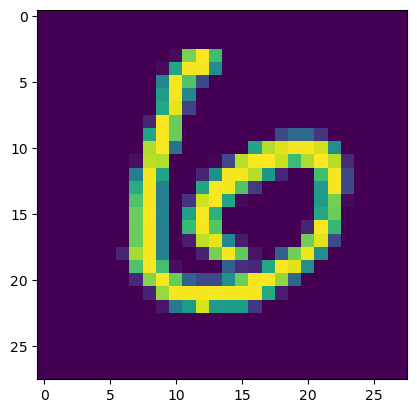

In [20]:
# Los datos ya estan incorporados en Keras, los cargamos con esta función
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# visualizamos la imagen 8
plt.imshow(x_test[11])
plt.show()


Fíjate que en una única llamada a mnist.load_data() hemos cargado todo, los conjuntos de entrenamiento (x_train, y_train) y los conjuntos de evaluación (x_test, y_test)

No te preocupes mucho, simplemente Keras ha definido la carga de esos ficheros de esa manera.

La última parte del código sirve para visualizar las imágenes


```
# visualizamos la imagen 8
plt.imshow(x_train[8])
plt.show()
```
Si cambias el número 8 puedes ir viendo otras imágenes, tienes 60000 para elegir. Aunque aparezca en color es por la función usada imshow que las colorea, en realidad son escala de grises

In [4]:
print(x_train)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [5]:
# comprobamos las caracteristicas del set de entrenamiento
print(x_train.ndim)
print(x_train.shape)
print(y_train.ndim)
print(y_train.shape)

3
(60000, 28, 28)
1
(60000,)


Las dimensiones son las correctas, x es una matriz de 3 dimensiones: 60000x28x28 e y un vector de 600000

In [6]:
# guardamos las dimensiones en variables para hacer la red mas generica
# y reutilizable

ntrain = x_train.shape[0]
ntest  = x_test.shape[0]
dimf = x_train.shape[1]
dimc = x_train.shape[2]

print("dimensiones: ", ntrain, ntest, dimf, dimc)

dimensiones:  60000 10000 28 28


##Preprocesado

Hay que preparar las imágenes para que entren en la red, vamos a hacer dos cosas:
1. Vectorizarlas
1. Normalizarlas, haciendo que vayan de 0 a 1 en vez de 0 a 255
1. Convertir y en una matriz one hot


In [7]:
# Preprocesamos los datos vectorizando y normalizando las imagenes

x_train = x_train.astype('float32')/255.
x_train = x_train.reshape(ntrain, dimf*dimc)

x_test = x_test.astype('float32')/255.
x_test = x_test.reshape(ntest, dimf*dimc)

# comprobamos que la dimension de x es correcta
print(x_train.shape)

(60000, 784)


Ahora tenemos 60000 vectores de 784 (28x28) píxeles


Creamos con y la matriz de onehot

In [8]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)

(60000, 10)


In [9]:
# Especificamos el modelo
# Una unica capa oculta con 10 sigmoides
# Una capa de salida con 10 softmax, una para cada categoria

model = keras.Sequential()
model.add(Dense(10, activation='sigmoid', input_shape=(dimf*dimc,)))
model.add(Dense(10, activation = 'softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
Total params: 7960 (31.09 KB)
Trainable params: 7960 (31.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# compilamos el modelo
model.compile(loss="categorical_crossentropy",
              optimizer="sgd", # stochastic gradient descent
              metrics= ['accuracy'])


In [11]:
# compilamos el modelo


model.compile(loss="categorical_crossentropy",
              optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics= ['accuracy'])


In [12]:
# hacemos el entrenamiento

history = model.fit(x_train, y_train, epochs=100,  batch_size=1000)

Epoch 1/100
60/60 [==============================] - 0s 2ms/step - loss: 2.0313 - accuracy: 0.4046
Epoch 2/100
60/60 [==============================] - 0s 2ms/step - loss: 1.7076 - accuracy: 0.5632
Epoch 3/100
60/60 [==============================] - 0s 1ms/step - loss: 1.5063 - accuracy: 0.6425
Epoch 4/100
60/60 [==============================] - 0s 2ms/step - loss: 1.3489 - accuracy: 0.7078
Epoch 5/100
60/60 [==============================] - 0s 1ms/step - loss: 1.2159 - accuracy: 0.7625
Epoch 6/100
60/60 [==============================] - 0s 1ms/step - loss: 1.1028 - accuracy: 0.7857
Epoch 7/100
60/60 [==============================] - 0s 1ms/step - loss: 1.0066 - accuracy: 0.7988
Epoch 8/100
60/60 [==============================] - 0s 1ms/step - loss: 0.9245 - accuracy: 0.8095
Epoch 9/100
60/60 [==============================] - 0s 1ms/step - loss: 0.8544 - accuracy: 0.8193
Epoch 10/100
60/60 [==============================] - 0s 2ms/step - loss: 0.7940 - accuracy: 0.8278
Epoch 11/

El batch_size no ha sido aún explicado, simplemente úsalo así, en esencia lo que estamos haciendo es utilizar lotes de 1000 y hacer el backpropagation, así se entrena la red mucho más rápido.



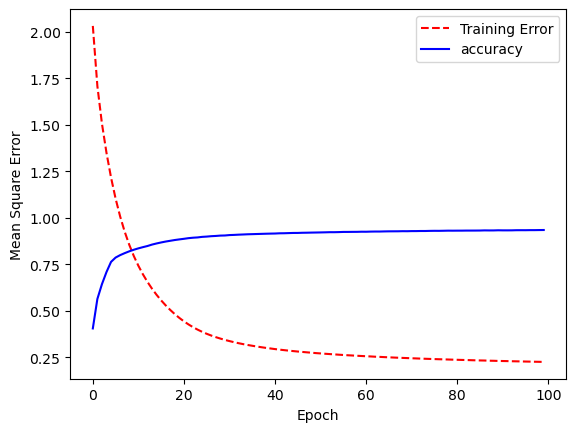

In [13]:
# hacemos un plot para ver si aprende adecuadamente
plot_history(history)

In [14]:
# evaluacion final con el test_set

test_loss, test_acc = model.evaluate(x_test, y_test)
print('test accuracy: ', test_acc)

313/313 [==============================] - 0s 471us/step - loss: 0.2542 - accuracy: 0.9250
test accuracy:  0.925000011920929


Aproximadamente un 83% de precisión en la clasificación. Está muy bien para ser matrices vectorizadas

Vamos a ver la salida de la capa de neuronas softmax, la salida de la red.

In [15]:
yp = model.predict(x_test)

print(yp[11])
print(np.argmax(yp[11]))


313/313 [==============================] - 0s 580us/step
[1.6401574e-03 1.3111233e-04 4.2205947e-03 4.8968277e-04 1.1686579e-02
 2.1266122e-03 9.7328466e-01 2.3532046e-03 4.0285392e-03 3.8835100e-05]
6


La categoria final es la de la neurona que tenga el valor más alto. En este caso la 6 (en python se empieza a contar en 0)

# Ejercicio

Prueba a modificar los hiperparámetros de la red e incluso su arquitectura para obtener una mejor clasificación. Por ejemplo podrías hacer lo siguiente:

1. Prueba a utilizar otros tipos de neuronas (RelU o tanh)
1. Prueba a incrementar el número de capas y de neuronas
1. Prueba a cambiar el batch_size
1. Prueba a utilizar otros optimizadores como adam o RMSprop



```
model.compile(loss="categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(lr=0.001),
              metrics= ['accuracy'])
```



```
model.compile(loss="categorical_crossentropy",
              optimizer= tf.keras.optimizers.RMSprop(lr=0.001),
              metrics= ['accuracy'])
```


Haz las pruebas que consideres interesantes e interpreta los resultados.

Pega el código empleado (solo las partes que has cambiado) en la ventana de abajo

Para saber cómo modificar la red o cambiar de optimizador simplemente usa google, te aportará miles de ejemplos

Recuerda que los resultados tienes que subirlos a un cuestionario de moodle